# General data reader for AQUA 
## Spatial regridding

The reader includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

The regridding weights are generated automatically by the reader if not already existant and stored in a directory specified in the `config/regrid.yaml` file. The same file also contains a list of predefined target grids (only regular lon-lat for now). For example "r100" is a regular grid at 1° resolution.

CDO is used for generating the weights and it will be needed in your environment. CDO is not needed to use the regridder, only to generate the weights. The regridder configuration file also stores for now (this may be modified in the future) information on files containing a grid description for different data sources. 

For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
import sys
#sys.path.append("../..")  # hack to import module -- to be removed later

from aqua import Reader, catalogue

### Example 1: IFS

We load IFS data specifying that we wish to regrid them to a 0.1° grid.

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r010")
data = reader.retrieve(fix=False)

by deafault, the data are still on the raw original grid. Let's look at temperature

In [3]:
data["2t"][1,:]

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

... but we can now ask to regrid it (or part of it) to the destination grid which we chose when we instantiated the reader.

In [4]:
tasr = reader.regrid(data["2t"][0:3,:])

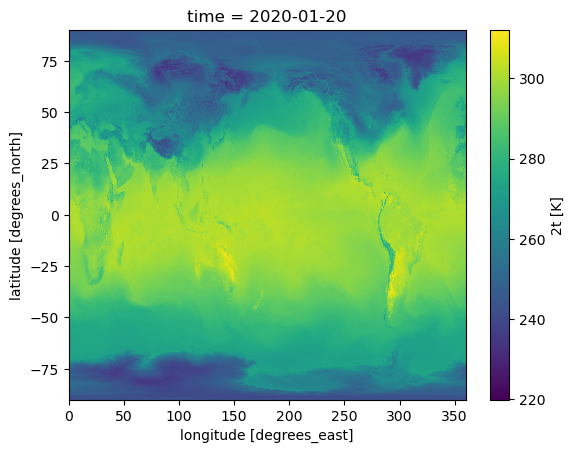

In [5]:
tasr[0,:,:].plot()

### Example 2: ICON

Instantiate a reader for ICON data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [6]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r200")

Load the actual data. By default these data have not been regridded yet. 

You could ask to regrid them directly by specifying the argument `regrid=True` but please be warned that without a selection on dates this will take longer. It is usually more efficient to first load the data, select and then regrid.

In [7]:
data = reader.retrieve()

No fixes defined for model  ICON


By default these data have not been regridded yet

In [8]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 152214
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Now we actually regrid part of the data (the first 96 frames)

In [9]:
tasr = reader.regrid(data.tas[1:100,:]) 

In [10]:
tasr

<xarray.DataArray 'tas' (time: 99, lat: 90, lon: 180)>
dask.array<reshape, shape=(99, 90, 180), dtype=float64, chunksize=(6, 90, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:30:00 ... 2020-01-22T01:30:00
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes:
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K
    regridded:                    1

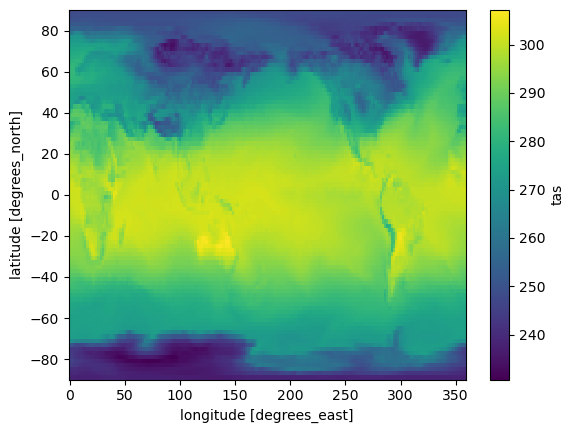

In [11]:
tasr.mean("time").plot()

### Example 3: Healpix data (ICON)

We can  read healpix data. Healpix implements the `zoom` parameter. `zoom=9` (default) is 12.5 Km, every lower number halves resolution. 

In [12]:
from aqua import Reader, catalogue
reader = Reader(model="ICON", exp="hpx", zoom=9, regrid="r100")
data = reader.retrieve()

Source areas file not found: /work/bb1153/b382075/nextgems/weights/cell_area_ICON_hpx_result.nc
Attempting to generate it ...
Source grid:  /work/bb1153/b382075/nextgems/grids/icon_hpx0.nc
Success!
No fixes defined for model  ICON


In [13]:
data

<xarray.Dataset>
Dimensions:             (time: 8640, pix: 3145728, level: 90, crs: 1)
Coordinates:
  * crs                 (crs) int16 0
  * level               (level) int32 0 1 2 3 4 5 6 7 ... 83 84 85 86 87 88 89
  * time                (time) datetime64[ns] 2020-07-23T00:30:00 ... 2021-01-19
Dimensions without coordinates: pix
Data variables:
    10m_wind_speed      (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cli                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    clivi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cllvi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clw                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    sea_level_pressure  (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    tas                 (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>

Let's first plot the original healpix data

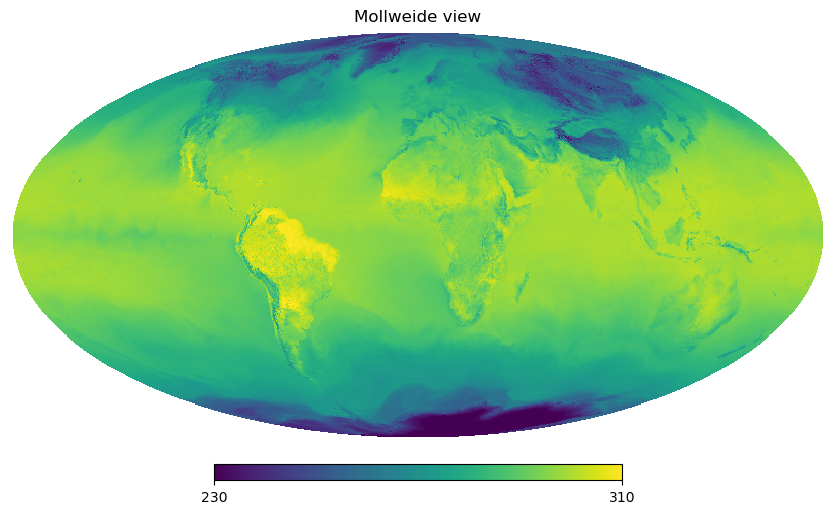

In [14]:
import healpy
healpy.visufunc.mollview(
    data.tas.sel(time="2020-11-02T19:00:00").values,
    nest=True, flip="geo", min=230, max=310)

Now we regrid

In [15]:
tasr = reader.regrid(data.tas)

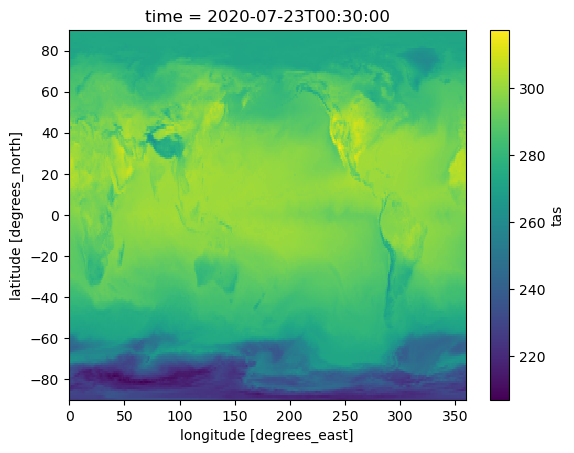

In [16]:
tasr[0,:,:].plot()

We can also compute spatial field averages: 

### Example 4: Hi-res interpolated FESOM data - with further interpolation

These are masked 3d data. For now (working on it), we can only interpolate one level at the time. So a level has to be specified and the retrieve method will only provide data from that level. An error is raised if level is not specified in this case.

In [17]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS", regrid="r100", level=20)

Source areas file not found: /work/bb1153/b382075/nextgems/weights/cell_area_FESOM_tco2559-ng5_interpolated_global_TS.nc
Attempting to generate it ...
Source grid:  /work/bb1153/b382075/nextgems/grids/fesom_tco2559_interpolated_3d.nc
Success!


In [18]:
data = reader.retrieve()

By default these data have not been interpolated yet:

In [19]:
t = data.to.isel(time=0)
t

<xarray.DataArray 'to' (lat: 2700, lon: 5400)>
dask.array<getitem, shape=(2700, 5400), dtype=float32, chunksize=(900, 1800), chunktype=numpy.ndarray>
Coordinates:
    depth      float64 105.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    time       datetime64[ns] 2020-01-20T02:56:00
    latitude   (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>
    longitude  (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>
Attributes:
    units:         K
    target_units:  K
    factor:        1
    offset:        273.15
    src_units:     degC
    units_fixed:   1

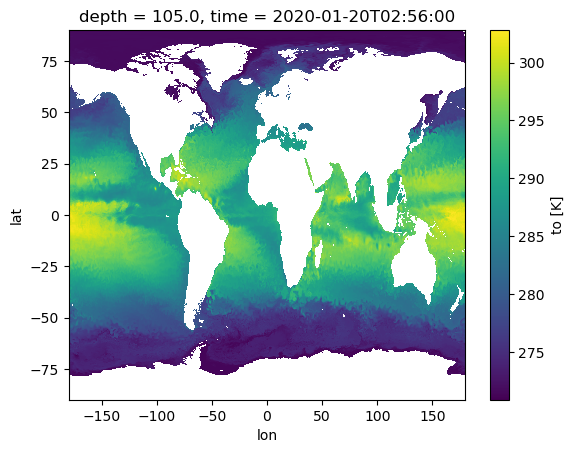

In [20]:
t.plot()

Now we actually regrid them

In [21]:
tr = reader.regrid(t)

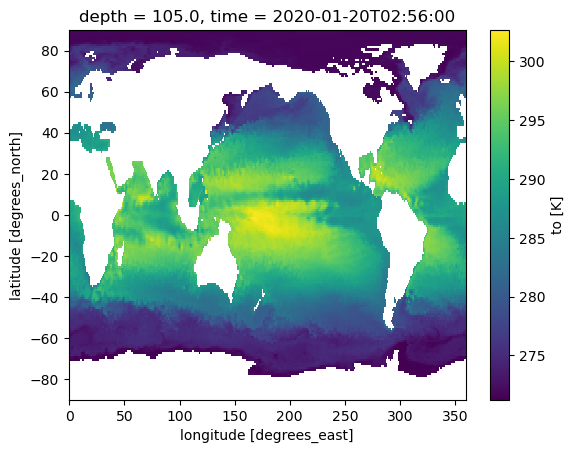

In [22]:
tr.plot()

### Example 5: Original FESOM data - further interpolation

In [27]:
from aqua import Reader, catalogue
reader = Reader(model="FESOM", exp="tco2559-ng5", source="original_2d", regrid="r250")

AttributeError: 'Dataset' object has no attribute 'cell_area'

In [ ]:
data = reader.retrieve()

In [ ]:
sst0=data.sst.isel(time=0)

In [ ]:
sst0

<xarray.DataArray 'sst' (nod2: 7402886)>
dask.array<getitem, shape=(7402886,), dtype=float32, chunksize=(7402886,), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-20T00:56:00
Dimensions without coordinates: nod2
Attributes:
    description:  sea surface temperature
    long_name:    sea surface temperature
    units:        C

In [ ]:
sstr = reader.regrid(sst0)

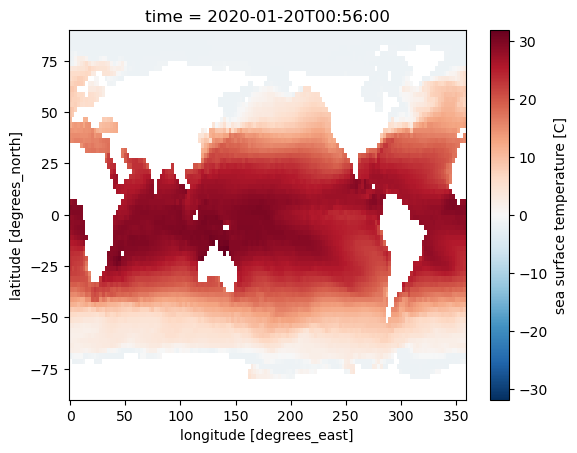

In [ ]:
sstr.plot()